In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters.py_dataset_adapter")
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.epoch_iterator")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress all warnings and info messages

In [2]:
import os
import subprocess
import zipfile

# Define dataset URL and paths
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4yIRGlIpNfKEGJYMhZV52g/fruits-360-original-size.zip"

local_zip = "fruits-360-original-size.zip"
extract_dir = "fruits-360-original-size"

def download_dataset(url, output_file):
    """Download the dataset using wget in quiet mode."""
    print("Downloading the dataset...")
    subprocess.run(["wget", "-q", "-O", output_file, url], check=True)  # Add `-q` for quiet mode
    print("Download completed.")

def extract_zip_in_chunks(zip_file, extract_to, batch_size=2000):
    """
    Extract a large zip file in chunks to avoid memory bottlenecks.
    Processes a specified number of files (batch_size) at a time.
    """
    print("Extracting the dataset in chunks...")
    os.makedirs(extract_to, exist_ok=True)  # Ensure the extraction directory exists
    
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        files = zip_ref.namelist()  # List all files in the archive
        total_files = len(files)
        
        for i in range(0, total_files, batch_size):
            batch = files[i:i+batch_size]
            for file in batch:
                zip_ref.extract(file, extract_to)  # Extract each file in the batch
            print(f"Extracted {min(i+batch_size, total_files)} of {total_files} files...")
    
    print(f"Dataset successfully extracted to '{extract_to}'.")

# Main script execution
if __name__ == "__main__":
    # Download the dataset if not already downloaded
    if not os.path.exists(local_zip):
        download_dataset(url, local_zip)
    else:
        print("Dataset already downloaded.")
    
    # Extract the dataset if not already extracted
    if not os.path.exists(extract_dir):
        extract_zip_in_chunks(local_zip, extract_dir)
    else:
        print("Dataset already extracted.")
    
    # Optional cleanup of the zip file
    if os.path.exists(local_zip):
        os.remove(local_zip)
        print(f"Cleaned up zip file: {local_zip}")

Download completed.
Extracting the dataset in chunks...
Extracted 2000 of 12481 files...
Extracted 4000 of 12481 files...
Extracted 6000 of 12481 files...
Extracted 8000 of 12481 files...
Extracted 10000 of 12481 files...
Extracted 12000 of 12481 files...
Extracted 12481 of 12481 files...
Dataset successfully extracted to 'fruits-360-original-size'.
Cleaned up zip file: fruits-360-original-size.zip


### Import necessary libraries and set dataset paths

- `ImageDataGenerator:` For loading images and applying data augmentation.
- `VGG16:` Pre-trained model used for transfer learning.
- `Sequential:` For building a sequential model.
- `Dense, Flatten, Dropout, BatchNormalization:` Layers to customize the model architecture.
- `ReduceLROnPlateau, EarlyStopping:` Callbacks for optimizing training.

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set dataset paths
train_dir = 'fruits-360-original-size/fruits-360-original-size/Training'
val_dir = 'fruits-360-original-size/fruits-360-original-size/Validation'
test_dir = 'fruits-360-original-size/fruits-360-original-size/Test'

### Set up data generators for training, validation, and testing with augmentation

- `train_datagen:` Applies rescaling and augmentation (e.g., rotation, zoom) to make the model more robust.
- `val_datagen and test_datagen:` Only rescale images for validation/testing.
- `flow_from_directory:` Loads images from specified folders into batches for training/validation/testing.

In [4]:
# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.


### Define the VGG16-based model architecture with custom layers
- `base_model:` Loads VGG16, excluding its dense layers (`include_top=False`).
- `for layer in base_model.layers:` Freezes VGG16 layers to retain pre-trained weights.
- Custom layers: Flatten the output, then add dense layers with regularization (Dropout) and normalization (BatchNormalization) to enhance learning.

In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout

# Load VGG16 with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])

### Compile the model with appropriate loss and optimizer
- `categorical_crossentropy:` Used because this is a multi-class classification task.
- `adam:` Adaptive learning rate optimizer that helps in faster convergence.
- `metrics=['accuracy']:` Tracks model accuracy.

In [6]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


### Train the model with early stopping and learning rate scheduling
- `ReduceLROnPlateau`: Reduces learning rate when validation loss plateaus, allowing better optimization.
- `EarlyStopping`: Stops training when validation loss no longer improves, preventing overfitting.
- `model.fit`: Trains the model on the `train_generator` and evaluates on `val_generator` each epoch.

In [7]:
import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy

# Define callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Enable mixed precision (if on GPU)
set_global_policy('float32')

steps_per_epoch = 50 
validation_steps = 25

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,  
    steps_per_epoch=steps_per_epoch,  
    validation_steps=validation_steps,  
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.1325 - loss: 3.1987 - val_accuracy: 0.1950 - val_loss: 2.5389 - learning_rate: 0.0010
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.4702 - loss: 1.7176 - val_accuracy: 0.4475 - val_loss: 2.0746 - learning_rate: 0.0010
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.5927 - loss: 1.3041 - val_accuracy: 0.5900 - val_loss: 1.7265 - learning_rate: 0.0010
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.6720 - loss: 1.0746 - val_accuracy: 0.5675 - val_loss: 1.4284 - learning_rate: 0.0010
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.7196 - loss: 0.9157 - val_accuracy: 0.6825 - val_loss: 1.1053 - learning_rate: 0.0010


### Fine-tune the model by unfreezing specific layers in VGG16
- `for layer in base_model.layers[-5:]`: Unfreezes the last 5 layers to allow fine-tuning.
-  Unfreezing fewer layers is faster and prevents overfitting on small datasets.
- `RMSprop(learning_rate=1e-5)`: Optimizer with a lower learning rate to fine-tune carefully without drastic weight changes.


In [8]:
# Import necessary libraries
import tensorflow as tf  # Import TensorFlow for accessing tf.keras
from tensorflow.keras.optimizers import Adam

# Check the number of layers in the base model
num_layers = len(base_model.layers)
print(f"The base model has {num_layers} layers.")

# Unfreeze the last 5 layers for fine-tuning
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Freeze BatchNorm layers to speed up fine-tuning
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Re-compile the model with a faster optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),   # Higher learning rate for faster convergence
    metrics=['accuracy']
)

# Continue training with fewer steps per epoch
history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,  # Reduced steps per epoch
    validation_steps=validation_steps,  # Reduced validation steps
    callbacks=[lr_scheduler, early_stopping]
)

The base model has 19 layers.
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step - accuracy: 0.7582 - loss: 0.8498 - val_accuracy: 0.7775 - val_loss: 0.8511 - learning_rate: 1.0000e-05
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 0.7416 - loss: 0.7324 - val_accuracy: 0.8675 - val_loss: 0.5352 - learning_rate: 1.0000e-05
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.7942 - loss: 0.6580 - val_accuracy: 0.8250 - val_loss: 0.5334 - learning_rate: 1.0000e-05
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.8289 - loss: 0.5877 - val_accuracy: 0.8525 - val_loss: 0.4561 - learning_rate: 1.0000e-05
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - accuracy: 0.8379 - loss: 0.5445 - val_accuracy: 0.9100 - val_loss: 0.3477 - learning_rate: 1.0000e-05


### Evaluate the model on the test set and display accuracy
- `model.evaluate(test_generator)`: Evaluates the model on the test set and prints accuracy, giving a final measure of model performance.

In [9]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=50)
print(f"Test Accuracy: {test_accuracy:.2f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9349 - loss: 0.3200
Test Accuracy: 0.93


### Visualize training performance with accuracy and loss curves
- Visual comparison shows if the model is overfitting, underfitting, or learning effectively.

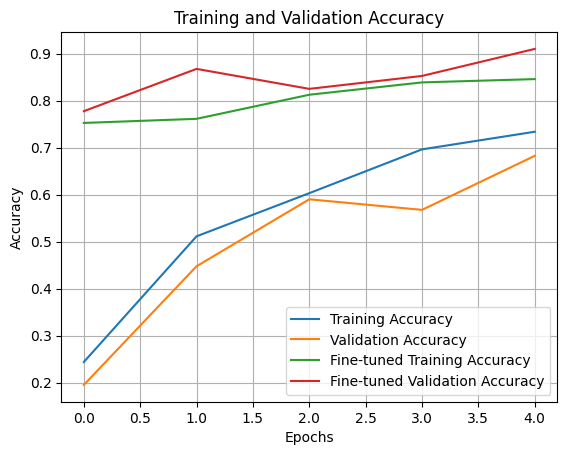

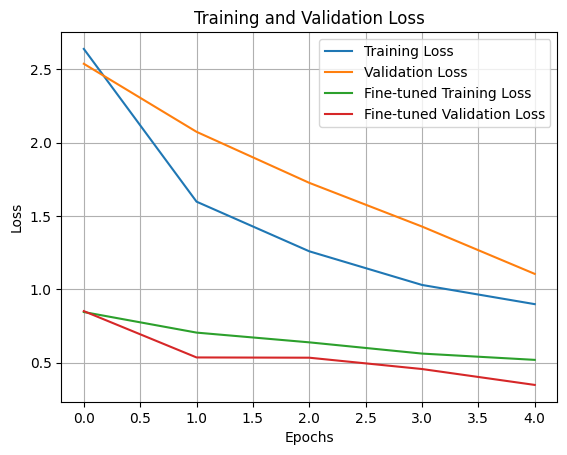

In [10]:
# Plot accuracy and loss curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuned Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuned Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuned Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tuned Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()